In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import glob

In [7]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

#ee.Initialize()

In [8]:
#Station coordinates (FLATS around stations?)

stazioni = pd.read_csv('C:/Users/arj26323/Documents/Data/NERR data/All_stations2.csv')

# print(stazioni['Station Code'].unique())

stazioni = stazioni[stazioni['Station Code'].str.contains('nut')]

stazioni.rename(columns={"Latitude ": "Latitude", " Longitude": "Longitude"}, inplace= True)

dfs = stazioni[['Station Code', 'Station Name', 'Latitude', 'Longitude']].reset_index()

dfs

,index,Station Code,Station Name,Latitude,Longitude
0,0,acebbnut,Big Bay,32.49410,-80.32410
1,3,acefcnut,Fishing Creek,32.63593,-80.36556
2,5,acemcnut,Mosquito Creek,32.55580,-80.43800
3,8,acespnut,St. Pierre,32.52800,-80.36144
4,11,aceeinut,Edisto Island,32.50400,-80.32470
...,...,...,...,...,...
147,340,wkbwsnut,Weather Station,30.41481,-87.82600
148,344,wqbcrnut,Childs River,41.57980,-70.53090
149,347,wqbmhnut,Menauhant,41.55260,-70.54850
150,349,wqbmpnut,Metoxit Point,41.56890,-70.52160


In [14]:
dfx = dfs[dfs['Station Code']=='sapdcnut  '] #two spaces put in after each code for some stupid fucking reason

# dfs.iloc[0,0]

dfx

# dfx.iloc[0,2]

-81.2789

In [15]:
px = ee.Geometry.Point([dfx.iloc[0,4], dfx.iloc[0,3]])

px_buffer = px.buffer(10000)
#lon and lat

In [16]:
Map = geemap.Map(center=[31.3896,-81.2789], zoom=16)

Map.addLayer(px_buffer)

# Map

In [17]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)

gce_lter = geemap.shp_to_ee('F:/Wetlands shapefiles/GCE domain/GCE_LTER_boundary.shp')

#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(px.buffer(10000)) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band)


bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])


In [18]:
ultra_col = l5_col.merge(l7_col).merge(l8_col).merge(l9_col)

# ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).filterBounds(flux_ga)
ultra = ultra_col.filter(ee.Filter.calendarRange(2004, 2024,'year')).map(lambda image: image.clip(px)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

In [19]:
def point_extract(image):
    
    feature = image.sampleRegions(
        collection=px,
        scale=30,
        geometries=True)
    
    return feature.limit(5000)

In [20]:
im_list = ultra.toList(ultra.size())

In [21]:
#Extract time series for nutrient station
# #MUCH faster to just map it across the image collection - the for loop takes forever. Same result
# result_list = []

# for i in range(im_list.size().getInfo()):
#     try:
#         image = ee.Image(im_list.get(i))
#         point = px
#         result = geemap.ee_to_pandas(point_extract(image, point))
#         result_list.append(result)
#     except Exception:
#         continue

# # Merge the results into a single dataframe
# timeseries_df = pd.concat(result_list)

feature_list = ultra.map(point_extract).flatten().toList(ultra.size())
values_list = []

# Loop through the feature list and extract values
for i in range(feature_list.size().getInfo()):
    feature = ee.Feature(feature_list.get(i))
    properties = feature.toDictionary()
    values_list.append(properties.getInfo())

# Convert the list of dictionaries to a pandas DataFrame
timeseries_df = pd.DataFrame(values_list)

# Print the DataFrame
print(timeseries_df)

KeyboardInterrupt: 

In [ ]:
timeseries_df

In [ ]:
import os
out_dir = os.path.expanduser('C:/Users/arj26323/Documents/Data/NERR data/')
out_csv = os.path.join(out_dir, 'timeseries_flats.csv')
# timeseries_df.to_csv(out_csv, index = False)

In [ ]:
timeseries_df = pd.read_csv('C:/Users/arj26323/Documents/Data/NERR data/timeseries_flats.csv')

In [8]:
timeseries_df['Date'] = pd.to_datetime(timeseries_df['acquisition_date'], unit = 'ms')
timeseries_df['DOY'] = timeseries_df['Date'].dt.strftime('%Y-%m-%d')
timeseries_df['DOY'] = pd.to_datetime(timeseries_df['DOY'])

timeseries_df

,ST_EMSD,ST_URAD,ST_TRAD,QA_RADSAT,ST_EMIS,SR_B2,SR_B3,SR_B4,ST_ATRAN,SR_B5,...,ST_CDIST,flats,SR_B1,ST_QA,ST_DRAD,SR_QA_AEROSOL,SR_B6,ST_B10,Date,DOY
0,72,4903,8603,0,9523,0.070902,0.060783,0.136050,3737,0.087402,...,20,0.030893,0.050057,651,2045,NaN,NaN,NaN,2004-06-22 15:36:16.360,2004-06-22
1,72,5292,8713,0,9523,0.040763,0.040130,0.163770,3212,0.090840,...,87,0.000549,0.029625,506,2172,NaN,NaN,NaN,2005-08-28 15:42:43.156,2005-08-28
2,72,4072,8713,0,9523,0.047528,0.045492,0.149030,4682,0.078052,...,124,0.004472,0.036060,431,1751,NaN,NaN,NaN,2005-09-13 15:42:44.548,2005-09-13
3,72,4264,8824,0,9523,0.050580,0.044145,0.117818,4475,0.082068,...,85,0.007604,0.035180,460,1829,NaN,NaN,NaN,2005-09-29 15:42:42.404,2005-09-29
4,72,1628,8824,0,9523,0.040212,0.043155,0.103710,7907,0.082287,...,115,0.010550,0.033090,341,787,NaN,NaN,NaN,2005-10-15 15:42:39.379,2005-10-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,72,844,9003,0,9645,0.033310,0.051185,0.045162,8749,0.074697,...,79,0.170420,0.025775,339,446,96.0,0.070022,300.032050,2023-04-23 16:00:38.084,2023-04-23
297,72,2834,9322,0,9645,0.054567,0.071645,0.064605,6461,0.091527,...,7,0.926906,0.045327,620,1304,96.0,0.058638,304.865130,2023-06-10 16:00:11.581,2023-06-10
298,72,4973,9256,0,9645,0.036472,0.044970,0.040295,3598,0.055310,...,59,0.912302,0.031852,451,2101,96.0,0.039800,316.923905,2023-06-26 16:00:08.772,2023-06-26
299,72,3898,9636,0,9645,0.057345,0.062900,0.059847,5423,0.108687,...,40,0.226979,0.053468,462,1727,96.0,0.078740,308.413035,2023-07-12 16:00:23.748,2023-07-12


<Axes: xlabel='Date', ylabel='flats'>

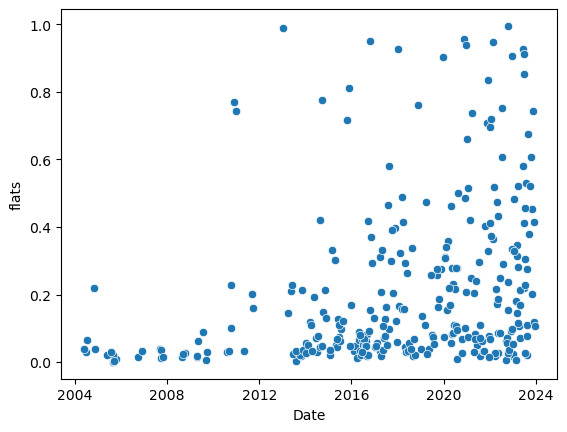

In [9]:
import seaborn as sns
sns.scatterplot(data = timeseries_df, x = 'Date', y = 'flats')

In [10]:
##LANDSAT ACQUISITION TIME!!! FOR TIDE/TIME MERGING

In [11]:
#Tides

path = r'C:/Users/arj26323/Documents/Data/Tide data/GA_FortPulaski'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_tides = pd.concat(li, axis=0, ignore_index=True)

df2 = df_tides.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])
df_time = df2.copy()
df_time['Verified (m)'] = df_time['Verified (m)'].replace('-', float('nan')).astype('float')
df_time = df_time.dropna()
df_time['Tide change'] = df_time['Verified (m)'].diff()
df_time['Tide stage'] = df_time['Tide change'].apply(lambda x: 'Ebb' if x < 0 else 'Flood')

time_mask = (df_time['Time (GMT)'].dt.hour == 16)

df_time = df_time[time_mask]


##Combine time/tide and flats data
df_combined = pd.merge(timeseries_df, df_time, on = 'DOY')
df_combined['Date'] = df_combined['Date_x']
df_combined

C:\Users\arj26323\AppData\Local\Temp\ipykernel_15136\3752195041.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])


,ST_EMSD,ST_URAD,ST_TRAD,QA_RADSAT,ST_EMIS,SR_B2,SR_B3,SR_B4,ST_ATRAN,SR_B5,...,Date_x,DOY,Date_y,Time (GMT),Predicted (m),Preliminary (m),Verified (m),Tide change,Tide stage,Date
0,72,4903,8603,0,9523,0.070902,0.060783,0.136050,3737,0.087402,...,2004-06-22 15:36:16.360,2004-06-22,2004/06/22,2024-05-06 16:00:00,1.743,-,1.873,0.047,Flood,2004-06-22 15:36:16.360
1,72,5292,8713,0,9523,0.040763,0.040130,0.163770,3212,0.090840,...,2005-08-28 15:42:43.156,2005-08-28,2005/08/28,2024-05-06 16:00:00,0.801,-,0.995,0.375,Flood,2005-08-28 15:42:43.156
2,72,4072,8713,0,9523,0.047528,0.045492,0.149030,4682,0.078052,...,2005-09-13 15:42:44.548,2005-09-13,2005/09/13,2024-05-06 16:00:00,0.690,-,0.884,0.284,Flood,2005-09-13 15:42:44.548
3,72,4264,8824,0,9523,0.050580,0.044145,0.117818,4475,0.082068,...,2005-09-29 15:42:42.404,2005-09-29,2005/09/29,2024-05-06 16:00:00,0.432,-,0.527,-0.229,Ebb,2005-09-29 15:42:42.404
4,72,1628,8824,0,9523,0.040212,0.043155,0.103710,7907,0.082287,...,2005-10-15 15:42:39.379,2005-10-15,2005/10/15,2024-05-06 16:00:00,0.290,-,0.654,-0.518,Ebb,2005-10-15 15:42:39.379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,72,373,7719,0,9645,0.028222,0.041092,0.039827,9388,0.093920,...,2023-02-18 16:01:11.781,2023-02-18,2023/02/18,2024-05-06 16:00:00,0.320,-,0.502,-0.583,Ebb,2023-02-18 16:01:11.781
285,72,844,9003,0,9645,0.033310,0.051185,0.045162,8749,0.074697,...,2023-04-23 16:00:38.084,2023-04-23,2023/04/23,2024-05-06 16:00:00,1.915,-,2.143,-0.091,Ebb,2023-04-23 16:00:38.084
286,72,2834,9322,0,9645,0.054567,0.071645,0.064605,6461,0.091527,...,2023-06-10 16:00:11.581,2023-06-10,2023/06/10,2024-05-06 16:00:00,1.370,-,1.772,0.602,Flood,2023-06-10 16:00:11.581
287,72,4973,9256,0,9645,0.036472,0.044970,0.040295,3598,0.055310,...,2023-06-26 16:00:08.772,2023-06-26,2023/06/26,2024-05-06 16:00:00,1.236,-,1.452,0.385,Flood,2023-06-26 16:00:08.772


<Axes: xlabel='Date', ylabel='flats'>

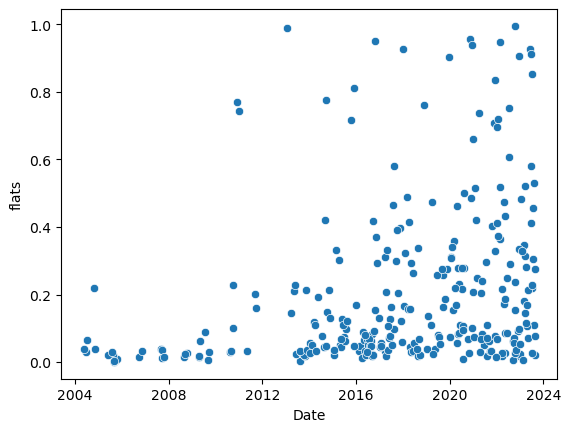

In [12]:
import seaborn as sns

# dfy = df_combined[df_combined['Verified (m)'] < 0.3]

sns.scatterplot(data = df_combined, x = 'Date', y = 'flats')

<Axes: xlabel='Verified (m)', ylabel='flats'>

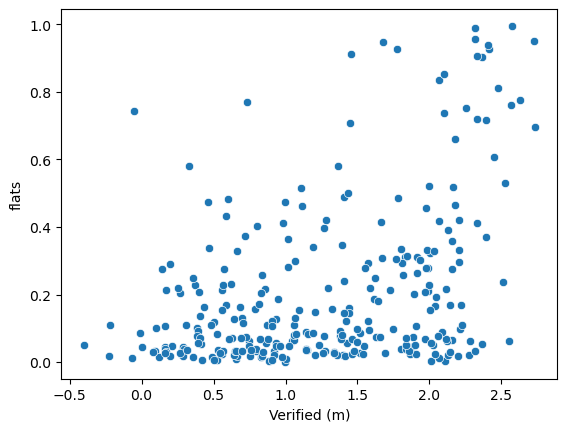

In [13]:
sns.scatterplot(data = df_combined, x = 'Verified (m)', y = 'flats') #This relationship is ok - mixed pixel

In [14]:
##Adding nutrient data

##SAP station
path = r'C:/Users/arj26323/Documents/Data/NERR data/Files 2024' #changed from Files folder 4/25/24
all_files = glob.glob(path + "/sapdcnut*.csv")

li = []

for filename in all_files:
    df_sap = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_sap)

df_sap = pd.concat(li, axis=0, ignore_index=True).dropna(subset=['NO23F']).dropna(axis=1)

##Begin:
df_sap = df_sap[df_sap['NO23F'] < 0.9] ##removes several extremely large outliers
df_sap['Date_m'] = pd.to_datetime(df_sap['DateTimeStamp'])
df_sap['DOY'] = df_sap['Date_m'].dt.strftime('%Y-%m-%d')
df_sap['DOY'] = pd.to_datetime(df_sap['DOY'])

df_sap

,StationCode,isSWMP,DateTimeStamp,Historical,ProvisionalPlus,CollMethd,REP,F_PO4F,F_NH4F,F_NO2F,F_NO3F,NO23F,F_NO23F,F_CHLA_N,Date_m,DOY
0,sapdcnut,P,09/22/2004 10:35,1,1,1,1,<4>,<4> H,<4> B - H,<4> B - C,0.0210,<4>,<4>,2004-09-22 10:35:00,2004-09-22
1,sapdcnut,P,09/22/2004 10:36,1,1,1,S,<4>,<4> H,<4> B - H,<4> B - C,0.0210,<4>,<4>,2004-09-22 10:36:00,2004-09-22
2,sapdcnut,P,09/22/2004 10:43,1,1,1,2,<4>,<4> H,<4> B - H,<4> B - C,0.0180,<4>,<4>,2004-09-22 10:43:00,2004-09-22
3,sapdcnut,P,09/22/2004 10:44,1,1,1,S,<4>,<4> H,<4> B - H,<4> B - C,0.0180,<4>,<4>,2004-09-22 10:44:00,2004-09-22
4,sapdcnut,P,09/22/2004 10:52,1,1,1,3,<4>,<4> H,<4> B - H,<4> B - C,0.0180,<4>,<4>,2004-09-22 10:52:00,2004-09-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,sapdcnut,P,10/20/2022 10:17,0,1,1,2,<0>,<0>,<0>,<0>,0.0101,<0>,<0>,2022-10-20 10:17:00,2022-10-20
772,sapdcnut,P,11/23/2022 9:42,0,1,1,1,<0>,<0>,<0>,<0>,0.0063,<0>,<0>,2022-11-23 09:42:00,2022-11-23
773,sapdcnut,P,11/23/2022 9:47,0,1,1,2,<0>,<0>,<0>,<-4> [SCB],0.0055,<-4> [SBL],<0>,2022-11-23 09:47:00,2022-11-23
774,sapdcnut,P,12/22/2022 9:20,0,1,1,1,<0>,<0>,<-4> [SBL],<-4> [SCB],0.0055,<-4> [SBL],<0>,2022-12-22 09:20:00,2022-12-22


<Axes: xlabel='Date_m', ylabel='NO23F'>

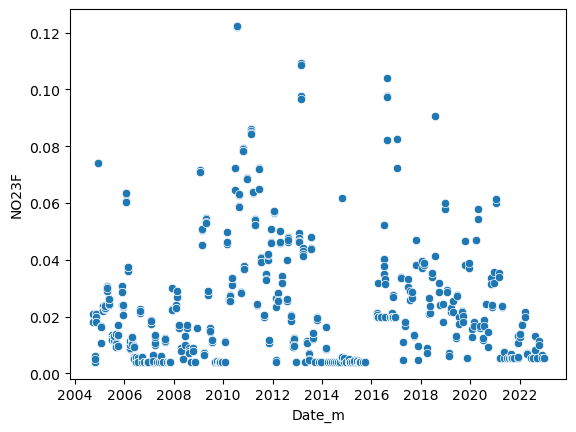

In [15]:
sns.scatterplot(data = df_sap, x = 'Date_m', y = 'NO23F')

In [16]:
##Combine nutrient data with flats and time/tide data
##Need to do merge_asof to take advantage of the large sample size for nutrient data
##Also, need to do a little pixel neighborhood, rather than a single pixel when analyzing FLATS/biomass (eventually)


# df_combined.columns = df_combined.columns.str.rstrip('_x') #remove suffix to avoid error
# df_combined2 = pd.merge(df_combined, df_sap, on = 'DOY')
# # df_combined2['Date'] = df_combined2['Date_']
# df_combined2.rename(columns={ df_combined2.columns[-1]: "Date_xxx" }, inplace = True)


##Merge, to nearest Landsat acquisition
df_combined2 = pd.merge_asof(
    df_combined.sort_values('Date'), 
    df_sap.sort_values('Date_m'), 
    left_on = 'Date',
    right_on = 'Date_m', 
    direction = 'nearest', 
    tolerance=pd.Timedelta("1210000000ms") ##Two weeks - is this ok?
)

df_combined2


,ST_EMSD,ST_URAD,ST_TRAD,QA_RADSAT,ST_EMIS,SR_B2,SR_B3,SR_B4,ST_ATRAN,SR_B5,...,REP,F_PO4F,F_NH4F,F_NO2F,F_NO3F,NO23F,F_NO23F,F_CHLA_N,Date_m,DOY_y
0,72,3350,8930,0,9557,0.058005,0.053962,0.106432,5522,0.085477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,72,4903,8603,0,9523,0.070902,0.060783,0.136050,3737,0.087402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
2,72,4777,9004,0,9557,0.054870,0.053358,0.107258,3977,0.075440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,72,3012,8297,0,9557,0.055640,0.060177,0.106597,5928,0.071755,...,S,<4>,<4>,<4> B,<4> B - C,0.005,<4>,<4>,2004-10-26 15:54:00,2004-10-26
4,72,3074,8658,0,9527,0.051102,0.047967,0.108330,6122,0.071315,...,1,<4>,<4>,<4> B,<4> B - C,0.021,<4>,<4>,2004-11-10 16:44:00,2004-11-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,72,4406,9461,0,9643,0.048435,0.068510,0.059875,4691,0.099695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
285,72,4706,9461,0,9629,0.044090,0.057180,0.051460,4281,0.117130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
286,72,4894,8781,0,9556,0.056327,0.044530,0.110145,3938,0.066915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
287,72,3509,9491,0,9631,0.047253,0.061937,0.054787,5805,0.085972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


In [17]:
len(df_combined2['NO23F'].dropna())

211

<Axes: xlabel='NO23F', ylabel='flats'>

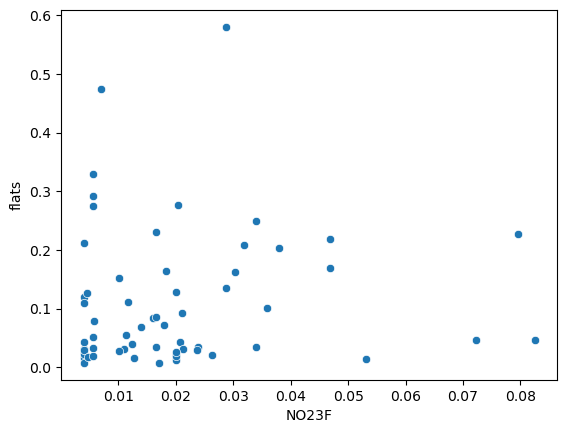

In [20]:
import seaborn as sns
import matplotlib as plt

dfz = df_combined2[df_combined2['Verified (m)'] < 0.7]

sns.scatterplot(data = dfz, x = 'NO23F', y = 'flats') ##This doesn't really tell you much. Need time + flats + N

In [19]:
print(dfz.shape)

##Tide quantiles will be different

max(dfz['Verified (m)'])

# dfz.quantile([.25, .5, 0.75])

df_combined['Verified (m)'].quantile([0,.25, .5, 0.75, 1])

(30, 50)


0.00   -0.400
0.25    0.658
0.50    1.275
0.75    1.915
1.00    2.732
Name: Verified (m), dtype: float64

In [ ]:
correlation = dfz['flats'].corr(dfz['NO23F'])
print(correlation)


##Time lag
lag = 0 #why choose this number?

no23_shifted = dfz['NO23F'].shift(-lag)

no23_shifted = no23_shifted.dropna()

# Calculate the correlation between the shifted variable and the original variable
time_lagged_corr = dfz['flats'].corr(no23_shifted)

# Print the time lagged correlation coefficient
print("Time lagged correlation coefficient between 'NO23F' and 'flats' (lag = {}): {:.2f}".format(lag, time_lagged_corr))

sns.scatterplot(x = no23_shifted, y = dfz['flats']) ##This doesn't really tell you much. Need time + flats + N

In [ ]:
sns.scatterplot(data = dfz, x = 'Date', y = 'flats')



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis (flats)
sns.scatterplot(ax=ax1, data=dfz, x='Date', y='flats', label='Flats', color='blue')
ax1.set_ylabel('Flats', color='blue', labelpad=10)

# Secondary y-axis (NO23F)
ax2 = ax1.twinx()  # Create a twin axis that shares the x-axis
sns.scatterplot(ax=ax2, data=dfz, x='Date', y='NO23F', label='NO23F', color='red')
ax2.set_ylabel('NO23F', color='red',  labelpad=15)

# Customize the plot further (optional)
# Place legend on primary y-axis
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left')  

# Alternatively, place legend on secondary y-axis
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, labels2, loc='upper right')


plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()